In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from scipy.sparse import hstack

import warnings
warnings.simplefilter(action='ignore')

In [2]:
df = pd.read_csv('../input/data-pre-processing-arabic-dialects/arabic_dialects_clean.csv',
                 lineterminator='\n')

df.tail()

,id,dialect,text,word_count,char_count,avg_char_per_word,stopwords,emoji_count,clean_text
457557,1019484980282580992,BH,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅,5,37,6.600000,0,1,مبسوطين منك اللي باسطانا
457558,1021083283709407232,BH,@Zzainabali @P_ameerah والله ماينده ابش يختي,6,44,6.500000,0,0,والله ماينده ابش يختي
457559,1017477537889431552,BH,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...,14,73,4.285714,1,2,شو عملنا لك حنا تهربي مننا احنا مساكين ليش بتع...
457560,1022430374696239232,BH,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋,6,43,6.333333,1,3,الله يبارك فيها وبالعافيه
457561,1022409931029458944,BH,@jolnar121 السحله ضيفي ي بتطلع لك سحليه😅😅,7,41,5.000000,2,2,السحله ضيفي ي بتطلع لك سحليه


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457562 entries, 0 to 457561
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 457562 non-null  int64  
 1   dialect            457562 non-null  object 
 2   text               457562 non-null  object 
 3   word_count         457562 non-null  int64  
 4   char_count         457562 non-null  int64  
 5   avg_char_per_word  457562 non-null  float64
 6   stopwords          457562 non-null  int64  
 7   emoji_count        457562 non-null  int64  
 8   clean_text         457562 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 31.4+ MB


<AxesSubplot:xlabel='dialect', ylabel='count'>

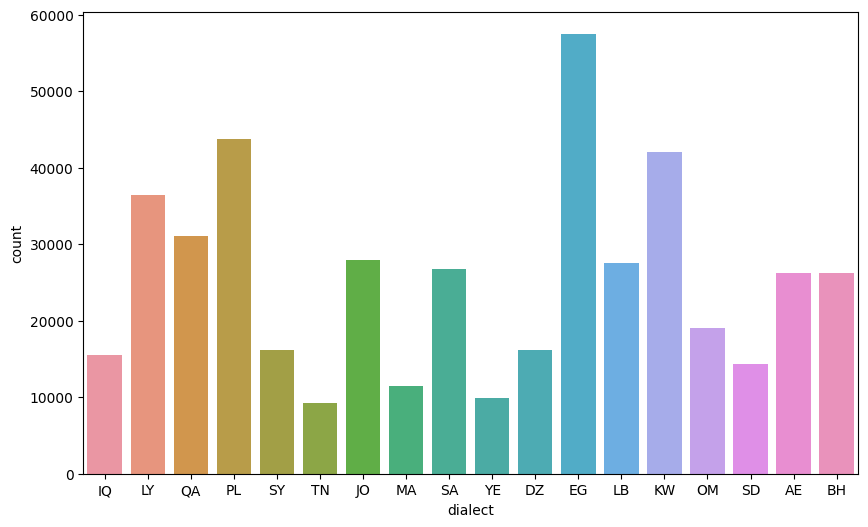

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(df['dialect'])

In [5]:
len(df['dialect'].unique())

18

## preprocessing

In [6]:
import pyarabic.araby as araby
import re

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

# Arabic stop words with nltk
stop_words = stopwords.words('arabic')
stop_words = [normalizeArabic(word) for word in stop_words]

In [7]:
X, X_test, y, y_test = train_test_split(df['clean_text'], df['dialect'], test_size=0.1,
                                        random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.11111, random_state=42)

print(len(y))
print(len(y_train))
print(len(y_val))
print(len(y_test))

411805
366049
45756
45757


#  Classification Models

# Naive Bayes

In [8]:
vectorizer = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.8, ngram_range=(1,2))
X_train_vectorize = vectorizer.fit_transform(X_train)
X_val_vectorize = vectorizer.transform(X_val)

nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_vectorize, y_train)

y_pred = nb.predict(X_train_vectorize)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          AE       0.55      0.56      0.55     20973
          BH       0.48      0.51      0.50     21098
          DZ       0.65      0.64      0.64     12919
          EG       0.71      0.87      0.78     45948
          IQ       0.72      0.64      0.68     12447
          JO       0.63      0.46      0.53     22184
          KW       0.58      0.64      0.61     33623
          LB       0.71      0.73      0.72     22193
          LY       0.72      0.72      0.72     29174
          MA       0.79      0.68      0.73      9233
          OM       0.59      0.50      0.54     15281
          PL       0.57      0.65      0.61     35138
          QA       0.57      0.58      0.57     24690
          SA       0.54      0.57      0.56     21357
          SD       0.79      0.66      0.72     11507
          SY       0.67      0.48      0.56     12992
          TN       0.80      0.54      0.65      7412
          YE       0.69    

In [9]:
y_pred = nb.predict(X_val_vectorize)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          AE       0.38      0.38      0.38      2639
          BH       0.31      0.31      0.31      2545
          DZ       0.57      0.51      0.54      1687
          EG       0.67      0.83      0.74      5823
          IQ       0.61      0.52      0.56      1529
          JO       0.41      0.29      0.34      2829
          KW       0.46      0.52      0.49      4231
          LB       0.61      0.64      0.62      2701
          LY       0.64      0.64      0.64      3611
          MA       0.68      0.59      0.64      1154
          OM       0.37      0.30      0.33      1869
          PL       0.43      0.53      0.48      4265
          QA       0.44      0.47      0.46      3227
          SA       0.37      0.39      0.38      2714
          SD       0.71      0.54      0.61      1466
          SY       0.43      0.27      0.33      1600
          TN       0.62      0.39      0.48       885
          YE       0.32    

## Naive Bayes with undersampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()

X_under, y_under = undersample.fit_resample(X_train.values.reshape(-1, 1),
                                            y_train)

X_under = pd.Series(X_under.reshape(1,-1)[0])

len(X_under)

133416

In [11]:
vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.8, ngram_range=(1,2))
X_train_vectorize = vectorizer.fit_transform(X_under)
X_val_vectorize = vectorizer.transform(X_val)

nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_vectorize, y_under)

y_pred = nb.predict(X_train_vectorize)
print(classification_report(y_under, y_pred))

              precision    recall  f1-score   support

          AE       0.95      0.97      0.96      7412
          BH       0.98      0.97      0.97      7412
          DZ       0.95      0.96      0.96      7412
          EG       0.92      0.99      0.95      7412
          IQ       0.98      0.96      0.97      7412
          JO       0.98      0.96      0.97      7412
          KW       0.96      0.98      0.97      7412
          LB       0.97      0.97      0.97      7412
          LY       0.98      0.97      0.98      7412
          MA       0.99      0.97      0.98      7412
          OM       0.98      0.96      0.97      7412
          PL       0.97      0.96      0.97      7412
          QA       0.95      0.98      0.96      7412
          SA       0.96      0.98      0.97      7412
          SD       0.98      0.97      0.97      7412
          SY       0.97      0.97      0.97      7412
          TN       0.97      0.97      0.97      7412
          YE       0.98    

In [12]:
y_pred = nb.predict(X_val_vectorize)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          AE       0.32      0.41      0.36      2639
          BH       0.32      0.23      0.27      2545
          DZ       0.45      0.54      0.49      1687
          EG       0.71      0.76      0.73      5823
          IQ       0.54      0.57      0.55      1529
          JO       0.37      0.29      0.33      2829
          KW       0.49      0.43      0.46      4231
          LB       0.57      0.63      0.60      2701
          LY       0.74      0.52      0.61      3611
          MA       0.58      0.65      0.61      1154
          OM       0.37      0.27      0.32      1869
          PL       0.51      0.35      0.42      4265
          QA       0.39      0.51      0.44      3227
          SA       0.34      0.38      0.36      2714
          SD       0.50      0.64      0.56      1466
          SY       0.34      0.39      0.37      1600
          TN       0.33      0.56      0.42       885
          YE       0.21    

# SGDClassifier

## combination of character and word n-grams

In [13]:
#TfidfVectorizer
vectorizer_word = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.8, ngram_range=(1,6))
vectorizer_char = CountVectorizer(stop_words=stop_words,min_df=10, max_df=0.8, analyzer='char', ngram_range=(3,7))

X_train_vectorize_word = vectorizer_word.fit_transform(X_train)
X_train_vectorize_char = vectorizer_char.fit_transform(X_train)

X_train_vectorize = hstack((X_train_vectorize_word, X_train_vectorize_char))
del X_train_vectorize_word
del X_train_vectorize_char

X_val_vectorize_char = vectorizer_char.transform(X_val)
X_val_vectorize_word = vectorizer_word.transform(X_val)

X_val_vectorize = hstack((X_val_vectorize_word, X_val_vectorize_char))
del X_val_vectorize_word
del X_val_vectorize_char

In [14]:
sgd = SGDClassifier(random_state=42, class_weight='balanced', max_iter=100)

sgd.fit(X_train_vectorize, y_train)

y_pred = sgd.predict(X_train_vectorize)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          AE       0.92      0.89      0.90     20973
          BH       0.82      0.93      0.87     21098
          DZ       0.97      0.89      0.93     12919
          EG       0.96      0.90      0.93     45948
          IQ       0.89      0.98      0.93     12447
          JO       0.86      0.91      0.89     22184
          KW       0.96      0.85      0.90     33623
          LB       0.95      0.91      0.93     22193
          LY       0.90      0.94      0.92     29174
          MA       0.98      0.95      0.96      9233
          OM       0.78      0.97      0.86     15281
          PL       0.84      0.91      0.87     35138
          QA       0.97      0.83      0.90     24690
          SA       0.90      0.91      0.90     21357
          SD       0.98      0.87      0.92     11507
          SY       0.91      0.94      0.92     12992
          TN       0.98      0.89      0.93      7412
          YE       0.86    

In [15]:
y_pred = sgd.predict(X_val_vectorize)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          AE       0.42      0.41      0.42      2639
          BH       0.30      0.35      0.32      2545
          DZ       0.62      0.50      0.56      1687
          EG       0.80      0.76      0.78      5823
          IQ       0.49      0.59      0.54      1529
          JO       0.35      0.36      0.36      2829
          KW       0.59      0.48      0.53      4231
          LB       0.65      0.62      0.64      2701
          LY       0.62      0.70      0.66      3611
          MA       0.69      0.60      0.64      1154
          OM       0.29      0.45      0.35      1869
          PL       0.42      0.51      0.46      4265
          QA       0.58      0.41      0.48      3227
          SA       0.39      0.38      0.38      2714
          SD       0.71      0.54      0.61      1466
          SY       0.37      0.36      0.37      1600
          TN       0.57      0.40      0.47       885
          YE       0.22    

In [16]:
del X_train_vectorize
del X_val_vectorize

# Final Model & Evaluation

In [17]:
vectorizer_word = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.8, ngram_range=(1,6))
vectorizer_char = CountVectorizer(stop_words=stop_words,min_df=10, max_df=0.8, analyzer='char', ngram_range=(3,7))
union = FeatureUnion([("vect_word", vectorizer_word),
                       ("vect_char", vectorizer_char)])

model = Pipeline([
           ('union', union),
           ('sgd', SGDClassifier(random_state=42, class_weight='balanced', max_iter=100)),
        ])

In [18]:
model.fit(X, y)

y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          AE       0.92      0.88      0.90     23612
          BH       0.77      0.93      0.85     23643
          DZ       0.96      0.88      0.92     14606
          EG       0.96      0.88      0.92     51771
          IQ       0.93      0.95      0.94     13976
          JO       0.82      0.91      0.86     25013
          KW       0.95      0.84      0.89     37854
          LB       0.94      0.92      0.93     24894
          LY       0.87      0.95      0.91     32785
          MA       0.98      0.94      0.96     10387
          OM       0.80      0.95      0.87     17150
          PL       0.85      0.89      0.87     39403
          QA       0.98      0.80      0.88     27917
          SA       0.89      0.90      0.90     24071
          SD       0.96      0.91      0.94     12973
          SY       0.89      0.94      0.92     14592
          TN       0.97      0.91      0.94      8297
          YE       0.85    

In [19]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AE       0.45      0.40      0.42      2663
          BH       0.29      0.40      0.34      2621
          DZ       0.60      0.48      0.53      1553
          EG       0.80      0.75      0.78      5770
          IQ       0.56      0.58      0.57      1506
          JO       0.36      0.40      0.38      2875
          KW       0.57      0.47      0.52      4225
          LB       0.62      0.65      0.63      2694
          LY       0.61      0.73      0.66      3668
          MA       0.73      0.62      0.67      1129
          OM       0.33      0.45      0.38      1936
          PL       0.45      0.51      0.48      4309
          QA       0.59      0.39      0.47      3121
          SA       0.39      0.39      0.39      2681
          SD       0.67      0.59      0.62      1415
          SY       0.38      0.37      0.37      1619
          TN       0.57      0.43      0.49       931
          YE       0.23    

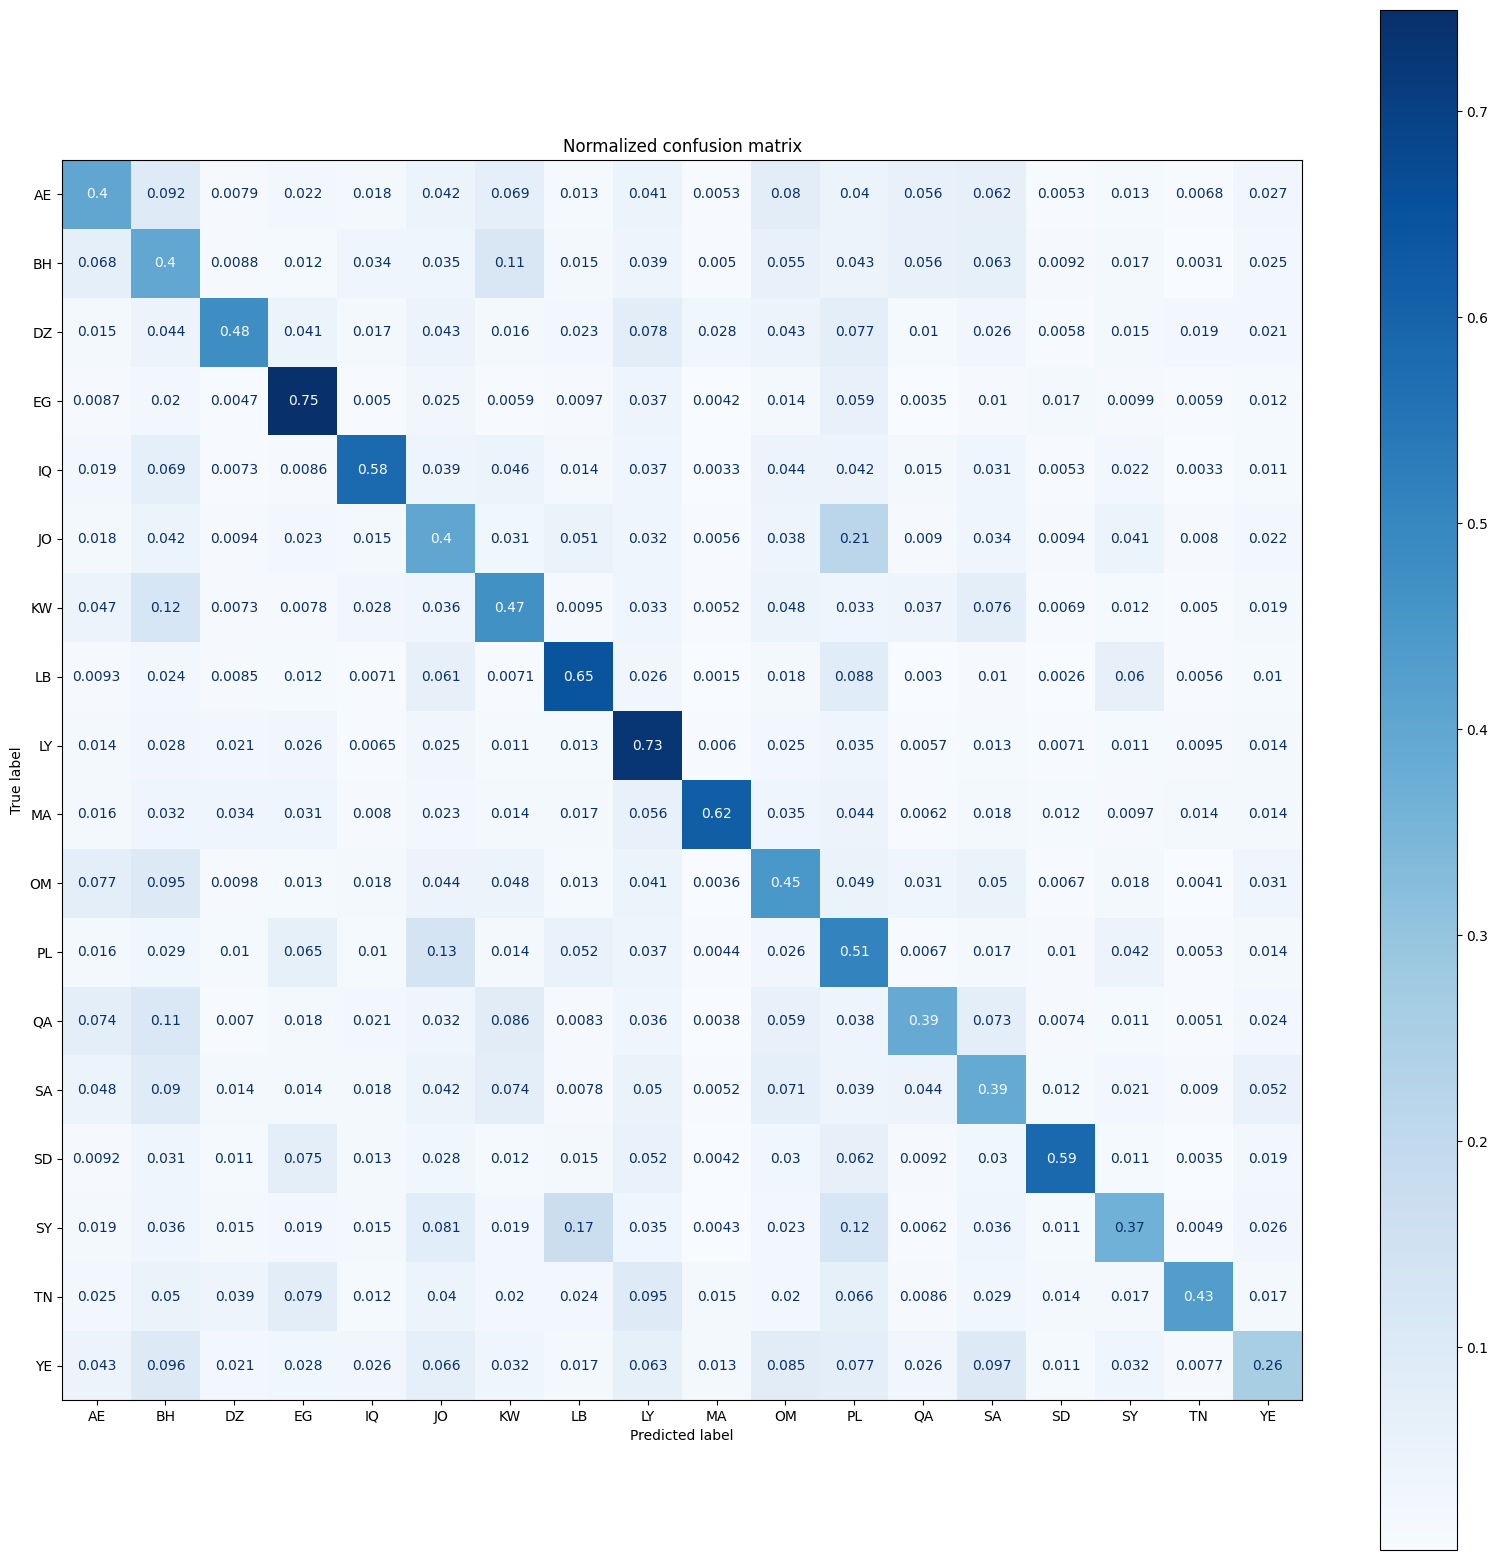

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("Normalized confusion matrix")
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=model.classes_,
    cmap=plt.cm.Blues,
    ax = ax,
    normalize='true')

In [21]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']